In [1]:
import dynamo as dyn
import numpy as np
from scipy import stats,signal
# import scvelo as scv
from matplotlib import pyplot as plt
from scipy import sparse
from sklearn.neighbors import KernelDensity
import networkx as nx
import os
import glob
import anndata
from scipy.interpolate import CubicSpline,interp1d
from voronoi_finite_polygons_2d import voronoi_finite_polygons_2d
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn import linear_model
from sklearn.feature_selection import VarianceThreshold
from scipy.sparse import csr_matrix

In [2]:
dim_n=10
result_path='result/'
adata=dyn.read(result_path+'EG_dyn.h5ad')
path=np.load(result_path+'EG_dyn_rc.npy')
rc_extend=np.load(result_path+'EG_rc_extend.npy')
gene_arr=np.load(result_path+'EG_bin_genes.npy',allow_pickle=True)

X0_bin=np.load(result_path+'EG_X0_bin.npy')

In [3]:
adata

AnnData object with n_obs × n_vars = 1731 × 470
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime', 'nGenes', 'nCounts', 'pMito', 'use_for_pca', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'Size_Factor', 'initial_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'ntr'
    var: 'highly_variable_genes', 'nCells', 'nCounts', 'pass_basic_filter', 'use_for_pca', 'frac', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics', 'use_for_transition'
    uns: 'PCs', 'clusters_colors', 'clusters_fine_colors', 'dynamics', 'explained_variance_ratio_', 'feature_selection', 'grid_velocity_pca', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca', 'pca_mean', 'pp'
    obsm: 'X', 'X_pca', 'X_umap', 'vel

In [4]:
adata.uns['explained_variance_ratio_']

array([0.10845514, 0.05125445, 0.01533655, 0.01149983, 0.0112549 ,
       0.00795938, 0.00746992, 0.00663746, 0.00647852, 0.00623623,
       0.00543208, 0.00529638, 0.00510862, 0.00487416, 0.00473567,
       0.0045281 , 0.00448922, 0.00431651, 0.00426171, 0.00414047,
       0.00405583, 0.00404247, 0.00396914, 0.00395733, 0.00388126,
       0.00381353, 0.00374944, 0.00374193, 0.00365371], dtype=float32)

In [5]:
V0_ori=adata.layers['velocity_S'].A
X0_ori=adata.layers['M_s'].A



In [6]:
from sklearn.impute import SimpleImputer,KNNImputer
# imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
# X0_ori=imp_mean.fit_transform(X0_ori)
# print(X0_ori.shape)
# imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
# V0_ori=imp_mean.fit_transform(V0_ori)


imputer = KNNImputer(n_neighbors=5)
X0_ori=imputer.fit_transform(X0_ori)
imputer = KNNImputer(n_neighbors=5)
V0_ori=imputer.fit_transform(V0_ori)


V0_ori.shape

(1731, 470)

In [7]:
X0=StandardScaler().fit_transform(X0_ori)
V0=StandardScaler().fit_transform(V0_ori)
print(X0.shape,V0.shape)
gene_list=adata.var.index.values

(1731, 470) (1731, 470)


In [8]:
# thres_arr=np.load(result_path+'EG_bin_genes_thres.npy',allow_pickle=True)
# X0_bin=X0_ori.copy()
# for i in range(X0_ori.shape[1]):
#     X0_bin[:,i][X0_ori[:,i]<thres_arr[i]]=0
#     X0_bin[:,i][X0_ori[:,i]>=thres_arr[i]]=1

In [9]:
bin_centers=np.load(result_path+'EG_bin_genes_center.npy',allow_pickle=True)
# print(bin_centers)
X0_bin=X0_ori.copy()
for i in range(X0_ori.shape[1]):
    gene_kc=bin_centers[i,:]
    x=X0_ori[:,i]
    x_dist0=abs(x-gene_kc[0])
    x_dist1=abs(x-gene_kc[1])
#     print(x_dist0)
    
#     print(x_dist0<x_dist1)
    
    X0_bin[:,i][x_dist0<x_dist1]=0
    X0_bin[:,i][x_dist0>=x_dist1]=1

In [10]:
data_rc=np.array([np.argmin(np.linalg.norm((adata.obsm['X_pca'][i,:dim_n]-rc_extend),axis=1)) for i in range(adata.shape[0])])
np.unique(data_rc,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
       dtype=int64),
 array([  7, 119,  50,  52,  56,  66, 104, 150, 111,  98,  89, 107, 155,
        114, 128, 253,  72], dtype=int64))

In [11]:
path_neigh=[[] for i in range(rc_extend.shape[0])]
for i in range(rc_extend.shape[0]):
#     mask=np.in1d(np.argsort(np.linalg.norm((adata.obsm['X_pca'][:,:dim_n]-path[i,:]),axis=1))[:200],np.where(data_rc==i)[0])
#     path_neigh[i]=np.argsort(np.linalg.norm((adata.obsm['X_pca'][:,:dim_n]-path[i,:]),axis=1))[:200][mask][:100].tolist()
#     print(len(path_neigh[i]))
    mask=np.in1d(np.where(data_rc==i)[0],np.argsort(np.linalg.norm((adata.obsm['X_pca'][:,:dim_n]-rc_extend[i,:]),axis=1))[:200])
    path_neigh[i]=np.where(data_rc==i)[0][mask].tolist()
    print(len(path_neigh[i]))

7
119
50
52
56
66
104
137
89
84
82
92
116
80
96
164
71


C:\Users\zoro\Anaconda3\envs\scrna\lib\site-packages\pandas-1.2.4-py3.7-win-amd64.egg\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


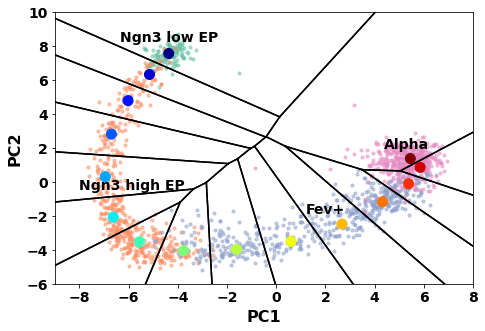

In [36]:
path_r=path.copy()
path_r[:,0]=-path[:,0]

t_list=['Ngn3 low EP', 'Ngn3 high EP', 'Fev+', 'Alpha']
fig,ax=plt.subplots(figsize=(7.5,5))
# ax.set_facecolor('silver')
colors =plt.cm.Set2([0,1,2,3])#plt.cm.Set2(np.linspace(0, 1, len(t_list)))
for ti in range(len(t_list)):                                      
    adata_t=adata[adata.obs['clusters']==t_list[ti],:]
    plt.scatter(-adata_t.obsm['X_pca'][:,0],adata_t.obsm['X_pca'][:,1],color=colors[ti],s=10,alpha=0.5)
    if ti==0: 
        plt.text(np.mean(-adata_t.obsm['X_pca'][:,0]),\
                 np.mean(adata_t.obsm['X_pca'][:,1])+1,\
                 t_list[ti],horizontalalignment='center',verticalalignment='center',\
                 fontweight='bold',fontsize=14,alpha=1,zorder=10)
        
    if ti==1: 
        plt.text(np.mean(-adata_t.obsm['X_pca'][:,0]),\
                 np.mean(adata_t.obsm['X_pca'][:,1])+0.5,\
                 t_list[ti],horizontalalignment='center',verticalalignment='center',\
                 fontweight='bold',fontsize=14,alpha=1,zorder=10)
        
    if ti==2: 
        plt.text(np.mean(-adata_t.obsm['X_pca'][:,0]),\
                 np.mean(adata_t.obsm['X_pca'][:,1])+0.5,\
                 t_list[ti],horizontalalignment='center',verticalalignment='center',\
                 fontweight='bold',fontsize=14,alpha=1,zorder=10)

    if ti==3: 
        plt.text(np.mean(-adata_t.obsm['X_pca'][:,0]),\
                 np.mean(adata_t.obsm['X_pca'][:,1])+1,\
                 t_list[ti],horizontalalignment='center',verticalalignment='center',\
                 fontweight='bold',fontsize=14,alpha=1,zorder=10)




    
# for i in range(len(path_neigh)):
#     plt.scatter(-adata.obsm['X_pca'][path_neigh[i],0],adata.obsm['X_pca'][path_neigh[i],1],marker='*',color='deepskyblue',s=5)#color=colors[i]

vor = Voronoi(path_r[:,:2])
regions, vertices = voronoi_finite_polygons_2d(vor,radius=200)
for region in regions:
    polygon = vertices[region]
    for i in range(0,len(polygon)-1):
        plt.plot([polygon[i,0],polygon[i+1,0]], [polygon[i,1],polygon[i+1,1]], linewidth=1.5,color='black')
    plt.plot([polygon[-1,0],polygon[0,0]], [polygon[-1,1],polygon[0,1]], linewidth=1.5,color='black')    
    
    
dot_color=np.arange(path.shape[0])
cm=plt.cm.get_cmap('jet')

plt.scatter(-path[:,0],path[:,1],s=100,c=dot_color,cmap=cm,zorder=10,alpha=1)

plt.xticks(fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold') 

plt.ylabel('PC2',fontsize=16,fontweight='bold')
plt.xlabel('PC1',fontsize=16,fontweight='bold')
plt.axis([-9,8,-6,10])
plt.savefig(result_path+'EG_rc_celltype.png',dpi=300)
plt.show()

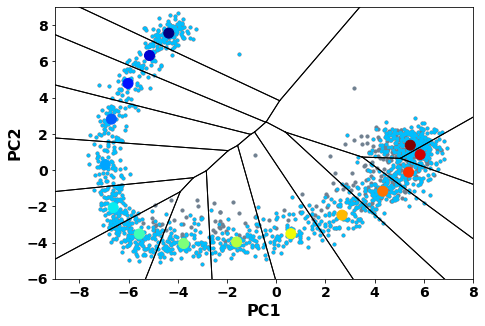

In [23]:
path_r=path.copy()
path_r[:,0]=-path[:,0]
fig,ax=plt.subplots(figsize=(7.5,5))
plt.scatter(-adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],color='slategrey',s=10,alpha=1)


colors =plt.cm.viridis(np.linspace(0, 1, len(path_neigh)))
for i in range(len(path_neigh)):
    plt.scatter(-adata.obsm['X_pca'][path_neigh[i],0],adata.obsm['X_pca'][path_neigh[i],1],color='deepskyblue',s=5)#color=colors[i]

vor = Voronoi(path_r[:,:2])
regions, vertices = voronoi_finite_polygons_2d(vor,radius=200)
for region in regions:
    polygon = vertices[region]
    for i in range(0,len(polygon)-1):
        plt.plot([polygon[i,0],polygon[i+1,0]], [polygon[i,1],polygon[i+1,1]], linewidth=1,color='k')
    plt.plot([polygon[-1,0],polygon[0,0]], [polygon[-1,1],polygon[0,1]], linewidth=1,color='k')
    
dot_color=np.arange(path.shape[0])
cm=plt.cm.get_cmap('jet')

plt.scatter(-path[:,0],path[:,1],s=100,c=dot_color,cmap=cm)

plt.xticks(fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold') 

plt.ylabel('PC2',fontsize=16,fontweight='bold')
plt.xlabel('PC1',fontsize=16,fontweight='bold')
plt.axis([-9,8,-6,9])
plt.savefig(result_path+'EG_rc_tube.png',dpi=300)
plt.show()

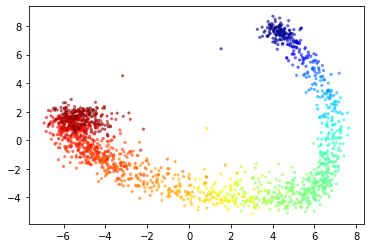

In [24]:
plt.scatter(adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],c=adata.obs['palantir_pseudotime'].values,cmap=plt.cm.jet,s=5,alpha=0.5)
plt.show()

In [25]:
sel=[j for nei in path_neigh[1:-1] for j in nei]
X0_ori_sel=X0_ori[np.unique(np.asarray(sel).flatten()),:]
X0_sel=StandardScaler().fit_transform(X0_ori_sel)
V0_ori_sel=V0_ori[np.unique(np.asarray(sel).flatten()),:]
V0_sel=StandardScaler().fit_transform(V0_ori_sel)

In [26]:
X0_bin[np.where(X0_bin==0)]=-1
X0_bin.shape

(1731, 470)

In [27]:
def net_frustration(X,V,F):
    frus_score=[]
    V_sign=np.sign(V)
#     F_sign=np.sign(F)
    for i in range(V.shape[0]):
        F_sign=np.sign((X[i,:]>0).astype(np.int)*((F*X[i,:]).T))
#         F_sign=np.sign(X[i,:]*((F*X[i,:]).T))
        edge_frus=F_sign#V_sign[i,:]*F_sign
#         print(np.sum(edge_frus),np.count_nonzero(F_sign))
        frus_ratio=(np.count_nonzero(F_sign)-np.sum(edge_frus))*0.5/np.count_nonzero(F)
        frus_score.append(frus_ratio)
    return np.array(frus_score)

In [28]:
def net_H(X,V,F):
    pseudo_h=[]
    V_sign=np.sign(V)
#     F_sign=np.sign(F)
    for i in range(V.shape[0]):
        F_sign=np.sign((X[i,:]>0).astype(np.int)*((F*X[i,:]).T))

        pseudo_h.append(-np.sum(F_sign))
    return np.array(pseudo_h)

In [29]:
# np.save(result_path+'EG_X_sel.npy',X0_sel.T)
# np.save(result_path+'EG_pt_sel.npy',adata.obs['palantir_pseudotime'].values[np.unique(np.asarray(sel).flatten())])

In [30]:
# #save single F
# pls2 = PLSRegression(n_components=2)
# pls2.fit(X0_sel, V0_sel)
# #---------row of F represent a gene's influence on other genes
# #----------column of F represent other gene's influence on this gene
# F=pls2.coef_

# Xf_mask=(VarianceThreshold().fit(X0)).variances_>=0
# Vf_mask=(VarianceThreshold().fit(V0)).variances_>=0

    
# row_inds=np.array([i*np.ones(np.where(Vf_mask)[0].shape) for i in np.where(Xf_mask)[0]]).flatten()
# col_inds=np.array([np.where(Vf_mask)[0] for i in np.where(Xf_mask)[0]]).flatten()

# inds=np.concatenate((row_inds[:,None],col_inds[:,None]),axis=1)
# F_sparse=np.concatenate((inds,F.flatten()[:,None]),axis=1)
# np.save(result_path+'dyn_EG_F.npy',F_sparse)

In [20]:
n=V0.shape[1]
print(n,X0_sel.shape)
F=np.zeros((n,n))
for i in range(n):
#     print(i)
    pls2 = PLSRegression(n_components=2)
    x=np.delete(X0_sel, i, 1)
    pls2.fit(x, V0_sel[:,i])
    fi=pls2.coef_
#     fi=fi/np.amax(fi)
#     plt.hist(fi,bins=50,edgecolor='k')
#     plt.show()
    if i==0:
        F[1:,i]=fi[:,0]
    elif i==n-1:
        F[:n-1,i]=fi[:,0]
    else:
        F[:i,i]=fi[:i,0]
        F[i+1:,i]=fi[i:,0]

F=F/np.amax(F)

470 (1387, 470)


In [67]:
Xf_mask=(VarianceThreshold().fit(X0)).variances_>=0
Vf_mask=(VarianceThreshold().fit(V0)).variances_>=0

    
row_inds=np.array([i*np.ones(np.where(Vf_mask)[0].shape) for i in np.where(Xf_mask)[0]]).flatten()
col_inds=np.array([np.where(Vf_mask)[0] for i in np.where(Xf_mask)[0]]).flatten()

inds=np.concatenate((row_inds[:,None],col_inds[:,None]),axis=1)
F_sparse=np.concatenate((inds,F.flatten()[:,None]),axis=1)
np.save(result_path+'dyn_EG_F.npy',F_sparse)

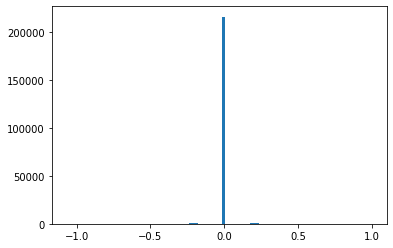

(5145,)


In [31]:
F_sparse=np.load(result_path+'sparse_EG_F.npy')
plt.hist(F_sparse[:,2],bins=100)
plt.show()
F=csr_matrix((F_sparse[:,2], (F_sparse[:,0], F_sparse[:,1])), shape=(V0.shape[1],V0.shape[1])).toarray()
print(np.where(F_sparse[:,2]!=0)[0].shape)

In [32]:
# path_neigh=[[] for i in range(path.shape[0])]
# for i in range(path.shape[0]):
# #     mask=np.in1d(np.argsort(np.linalg.norm((adata.obsm['X_pca'][:,:dim_n]-path[i,:]),axis=1))[:200],np.where(data_rc==i)[0])
# #     path_neigh[i]=np.argsort(np.linalg.norm((adata.obsm['X_pca'][:,:dim_n]-path[i,:]),axis=1))[:200][mask][:100].tolist()
# #     print(len(path_neigh[i]))
#     mask=np.in1d(np.where(data_rc==i)[0],np.argsort(np.linalg.norm((adata.obsm['X_pca'][:,:dim_n]-path[i,:]),axis=1))[:100])
#     path_neigh[i]=np.where(data_rc==i)[0][mask].tolist()
#     print(len(path_neigh[i]))

C:\Users\zoro\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


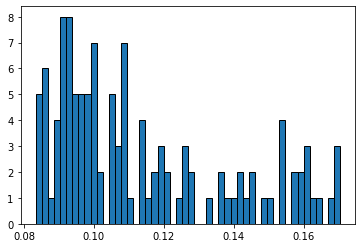

0.11353765996194394


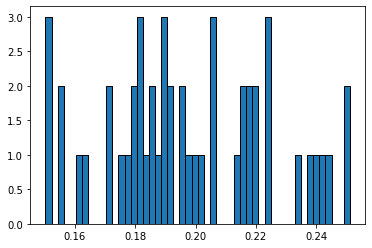

0.19766375121477162


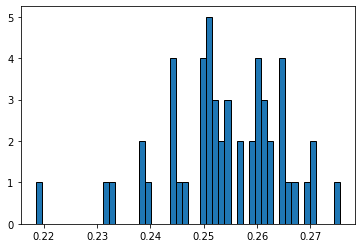

0.253991926440906


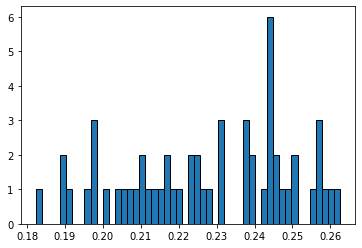

0.2274816048868527


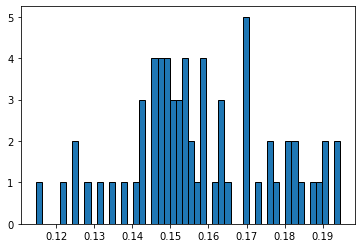

0.1578437435580293


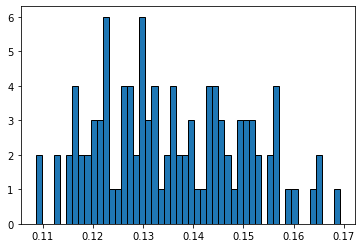

0.13561523510503104


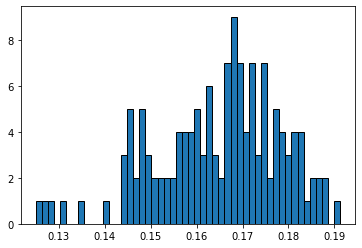

0.1646868549296674


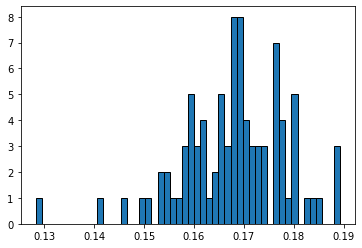

0.16788635197257076


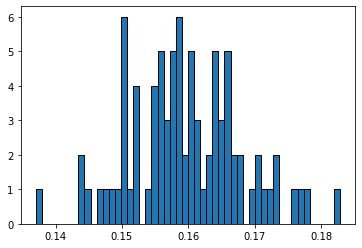

0.15967883752140313


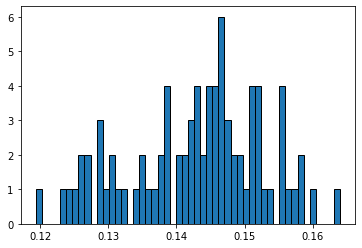

0.14293299201213586


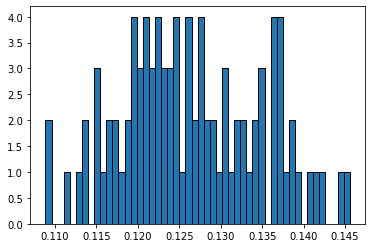

0.12641441669835637


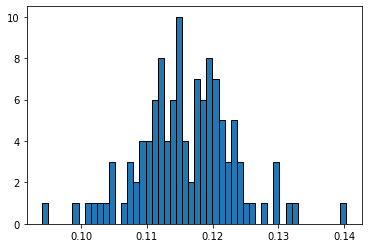

0.11599477229315373


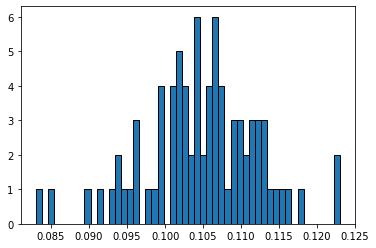

0.1047278911564626


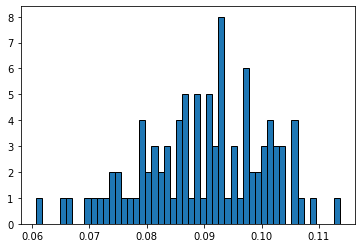

0.08991537091026887


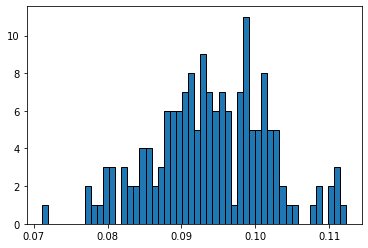

0.09394865960321412


In [33]:
frus_scores=[]
path_frus=[]

pseudo_H=[]
path_H=[]
# X_mask_thres=0
# V_mask_thres=0.01
# mask_thres=0
for i in range(1,rc_extend.shape[0]-1):

        
    

    X=X0[path_neigh[i]]
    V=V0[path_neigh[i]]
#     print(path_neigh[i])
    
    X_ori=X0_ori[path_neigh[i]]
    V_ori=V0_ori[path_neigh[i]]
    X_bin=X0_bin[path_neigh[i]]
#     print(X_bin)
    
#     F_sparse=np.load(result_path+'sparse_EG_F.npy')
#     plt.hist(F_sparse[:,2],bins=100)
#     plt.show()
#     F=csr_matrix((F_sparse[:,2], (F_sparse[:,0], F_sparse[:,1])), shape=(V0.shape[1],V0.shape[1])).toarray()
#     print(np.where(F_sparse[:,2]!=0)[0].shape)

    
#     mask=abs(F)>mask_thres#np.reshape(is_outlier(F.flatten(),thresh=5),F.shape)#
#     X_mask=X_ori>X_mask_thres
#     V_mask=abs(V_ori)>V_mask_thres

    group_frus_score=net_frustration(X_bin,V_ori,F)
    plt.hist(group_frus_score,bins=50,edgecolor='k')
    plt.show()
    frus_scores.append(group_frus_score)
    
    path_frus.append(np.mean(group_frus_score))
    print(np.mean(group_frus_score))
    group_H=net_H(X_bin,V_ori,F)
    pseudo_H.append(group_H)
    path_H.append(np.mean(group_H))

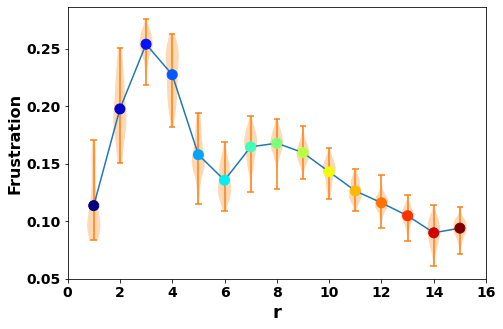

In [34]:


fig,ax=plt.subplots(figsize=(7.5,5))
dot_color=np.arange(path.shape[0])
cm=plt.cm.get_cmap('jet')
plt.plot(np.arange(path.shape[0])+1,path_frus)

plt.violinplot(frus_scores,positions=np.arange(path.shape[0])+1)
plt.scatter(np.arange(path.shape[0])+1,path_frus,s=100,c=dot_color,cmap=cm,zorder=10)
plt.ylabel('Frustration',fontsize=16,fontweight='bold')
plt.xlabel('r',fontsize=18,fontweight='bold')

plt.xticks(np.arange(17,step=2),fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')  
# plt.axis([0,16,0,0.4])
plt.savefig(result_path+'EG_frus.png',dpi=300)
plt.show()